In [2]:
import re
import random
import pandas as pd
import hashlib

In [3]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [4]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
FSLogix,84.947396,3.539475,24
Vocab,487.124572,44.284052,11
Azure Functions + Visual Studio,507.324648,36.237475,14
Audit Report Tracker (Sharepoint List),576.997928,36.062370,16
OData,678.228382,48.444884,14
Azure AI Search,753.237609,53.802686,14
Search Engine Optimization,836.836353,104.604544,8
Debugging in VS Code,856.249105,37.228222,23
PnP Powershell,931.173810,24.504574,38
Email Auth and Security,1159.205588,89.169661,13


# Histogram

43475.13


<Axes: >

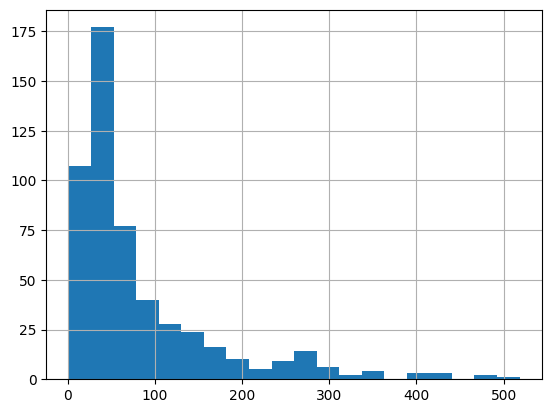

In [5]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [9]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [10]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [11]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [12]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [13]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [14]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Max

In [ ]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 528


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
5,Azure Kubernetes Learning Path,1. A container is launched using the --publish...,bdf9678837f298b5848a372aedc0d3be,-518.326312,197.949488,-518.326312,2573.343350,0.145093,0,0
83,Azure Kubernetes Learning Path,The following example creates an alias for the...,141254979388bea3e62d8f2681c057ca,-274.360527,197.949488,-518.326312,2573.343350,0.145093,3,0
161,Azure Kubernetes Learning Path,"To pause a running container, use the pause co...",6c3edb7ea37a0413de49e2edc592868c,-157.175359,197.949488,-518.326312,2573.343350,0.145093,6,0
235,Azure Kubernetes Learning Path,Azure Container Registry repositories are priv...,dc97a397e071244d4a2503be94dc0bab,-67.418972,197.949488,-518.326312,2573.343350,0.145093,9,0
307,Azure Kubernetes Learning Path,Dockerfile Example:\nFROM mcr.microsoft.com/do...,184ed4422a0154f25c101abff1d2fd76,-45.805737,197.949488,-518.326312,2573.343350,0.145093,12,0
41,Lost in a Good Book,"(Pair of) secateurs: A small, handheld pruning...",388965cf688c2f2d4c7f2d6297505c69,-469.027286,125.452025,-469.027286,2509.040507,0.461988,0,0
121,Lost in a Good Book,"Proleptic: Relating to anticipation, particula...",cfd611a9fc45962acd68c709459375df,-198.941932,125.452025,-469.027286,2509.040507,0.461988,3,0
199,Lost in a Good Book,Wisteria: A climbing flowering plant with frag...,41f99c38886a575deffe4cdb28b87571,-106.863844,125.452025,-469.027286,2509.040507,0.461988,6,0
272,Lost in a Good Book,Antimacassar: A small cloth placed on furnitur...,29a8f7ce49bb99808ebf61576b133725,-87.496835,125.452025,-469.027286,2509.040507,0.461988,9,0
336,Lost in a Good Book,Cornice: An architectural feature where a proj...,ac22db80f4792a978f820837f62d54eb,-73.058265,125.452025,-469.027286,2509.040507,0.461988,12,0


## Age Mean

In [16]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [17]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [18]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
5,Azure Kubernetes Learning Path,1. A container is launched using the --publish...,bdf9678837f298b5848a372aedc0d3be,-518.326312,197.949488,-518.326312,2573.343350,0.145093,0,0
83,Azure Kubernetes Learning Path,The following example creates an alias for the...,141254979388bea3e62d8f2681c057ca,-274.360527,197.949488,-518.326312,2573.343350,0.145093,3,0
161,Azure Kubernetes Learning Path,"To pause a running container, use the pause co...",6c3edb7ea37a0413de49e2edc592868c,-157.175359,197.949488,-518.326312,2573.343350,0.145093,6,0
235,Azure Kubernetes Learning Path,Azure Container Registry repositories are priv...,dc97a397e071244d4a2503be94dc0bab,-67.418972,197.949488,-518.326312,2573.343350,0.145093,9,0
307,Azure Kubernetes Learning Path,Dockerfile Example:\nFROM mcr.microsoft.com/do...,184ed4422a0154f25c101abff1d2fd76,-45.805737,197.949488,-518.326312,2573.343350,0.145093,12,0
41,Lost in a Good Book,"(Pair of) secateurs: A small, handheld pruning...",388965cf688c2f2d4c7f2d6297505c69,-469.027286,125.452025,-469.027286,2509.040507,0.461988,0,0
121,Lost in a Good Book,"Proleptic: Relating to anticipation, particula...",cfd611a9fc45962acd68c709459375df,-198.941932,125.452025,-469.027286,2509.040507,0.461988,3,0
199,Lost in a Good Book,Wisteria: A climbing flowering plant with frag...,41f99c38886a575deffe4cdb28b87571,-106.863844,125.452025,-469.027286,2509.040507,0.461988,6,0
272,Lost in a Good Book,Antimacassar: A small cloth placed on furnitur...,29a8f7ce49bb99808ebf61576b133725,-87.496835,125.452025,-469.027286,2509.040507,0.461988,9,0
336,Lost in a Good Book,Cornice: An architectural feature where a proj...,ac22db80f4792a978f820837f62d54eb,-73.058265,125.452025,-469.027286,2509.040507,0.461988,12,0


In [19]:
existing_cards.head(10)['age'].sum()

-1998.4750702681176